<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Configration" data-toc-modified-id="Configration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Configration</a></span></li><li><span><a href="#inverse-matrix" data-toc-modified-id="inverse-matrix-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>inverse matrix</a></span><ul class="toc-item"><li><span><a href="#1-thread,-x-MKL-threads" data-toc-modified-id="1-thread,-x-MKL-threads-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>1 thread, x MKL threads</a></span></li><li><span><a href="#x-threads-and-y-MKL-threads" data-toc-modified-id="x-threads-and-y-MKL-threads-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>x threads and y MKL threads</a></span></li></ul></li></ul></div>

# Configration

In [3]:
import platform
import numpy as np
import psutil
import time
import os
import mkl

print(platform.platform())
print(np.__version__)
np.show_config()
print(os.getenv("MKL_NUM_THREADS"))
print(mkl.__version__)
print(mkl.get_max_threads())
print(platform.processor())



import matplotlib.pyplot as plt         
def duration(f):
    t0 = time.time()
    f()
    t1 = time.time()
    return t1 - t0


Windows-10-10.0.19041-SP0
1.19.2
blas_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/liangh/Anaconda3\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/liangh/Anaconda3\\Library\\include']
blas_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/liangh/Anaconda3\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/liangh/Anaconda3\\Library\\include']
lapack_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/liangh/Anaconda3\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/liangh/Anaconda3\\Library\\include']
lapack_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/liangh/Anaconda3\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/liangh/Anaconda3\\Library\\include']
None
2.3.0


# inverse matrix

## 1 thread, x MKL threads

In [2]:
rm = np.random.randn(5000,5000)
time.sleep(2)

cpus = []
use_time = []
percent = []

    
def measure1():
    psutil.cpu_percent()
    for i in range(1, 16+1):

        mkl.set_num_threads(i)
        dur = duration(lambda: np.linalg.inv(rm))    
        c = psutil.cpu_percent()
        global cpus
        global use_time
        global percent
        cpus.append(i)
        use_time.append(dur)
        percent.append(c)
    
measure1()

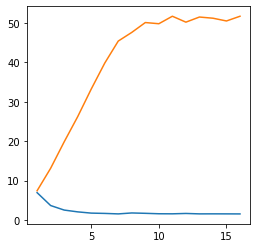

In [3]:
def plot():
    plt.figure(figsize=(4,4))
    plt.plot(cpus, use_time)
    plt.plot(cpus, percent)
    plt.gca().xaxis.get_major_locator().set_params(integer=True)
    plt.show()
plot()

## x threads and y MKL threads

In [39]:
import threading
def mat_inverse(x):
    np.linalg.inv(x)

def test(N):
    rm = np.random.randn(N,N)

    def inverse(rm, num_threads, mkl_num_threads):
        mkl.set_num_threads(mkl_num_threads)
        threads = [threading.Thread(target=mat_inverse, args=(rm,)) for i in range(num_threads)]
        for t in threads:
            t.start()
        for t in threads:    
            t.join()


    durs = [[duration(lambda: inverse(rm, i, mkl_n)) for i in range(1, 16+1)] for mkl_n in range(1, 8+1)]
    thread_num = [i for i in range(1, 16+1)]
    return durs, thread_num

def plot(durs, thread_num, max_num_threads=16, ylim=None):
    plt.figure(figsize=(12,12))
    thread_num = np.array(thread_num)[:max_num_threads]        
    workload_each_thread = 1. / thread_num
    
    for i in range(8):
        durs_ = np.array(durs[i])[:max_num_threads]
        
        plt.plot(thread_num, workload_each_thread *durs_, label="Num. MKL thr. %d"%(i+1))        
    plt.ylim((0, ylim))
    plt.xlabel("Num. thr.")
    plt.ylabel("Time / Num. of thr. (s)")
    plt.grid()
    
    plt.legend()
    plt.gca().xaxis.get_major_locator().set_params(integer=True)
    plt.show()

In [5]:
durs, thread_num = test(1000)

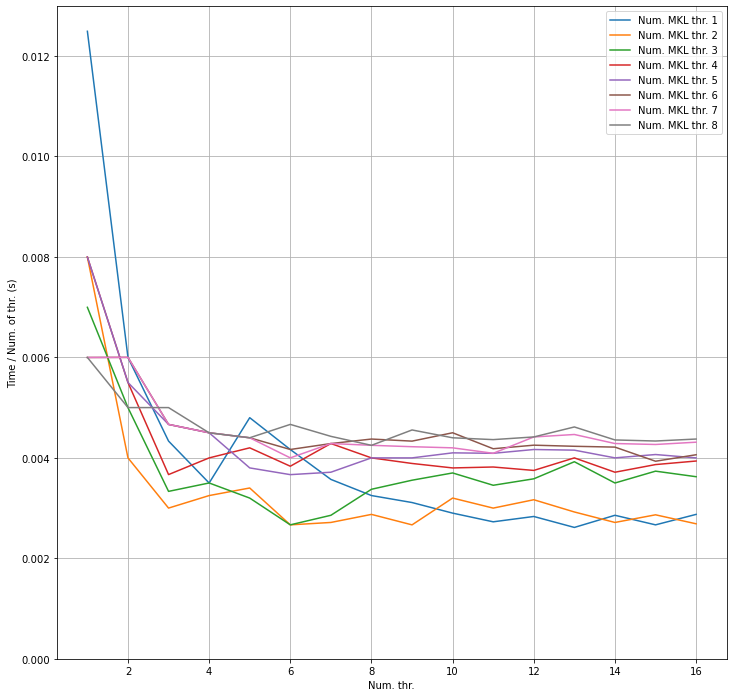

In [28]:
plot(durs, thread_num)

In [30]:
durs, thread_num = test(2000)

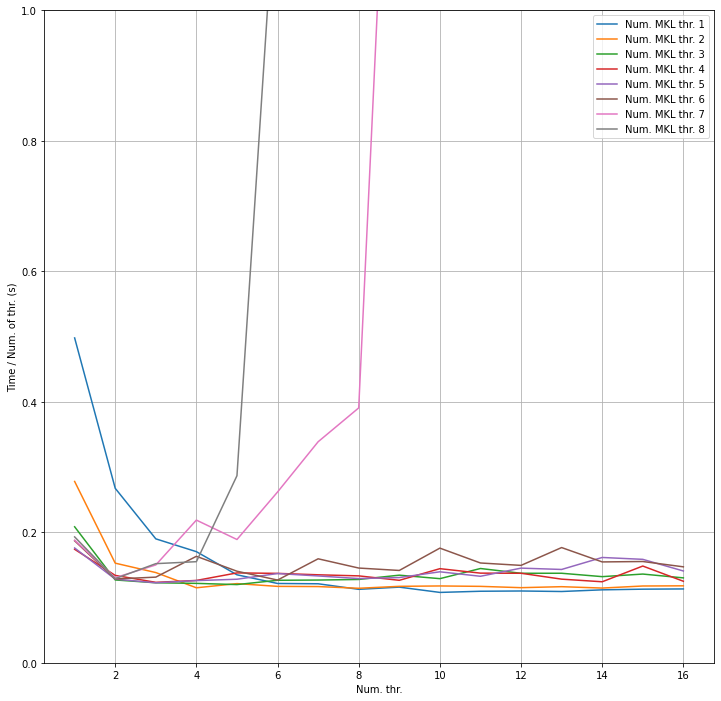

In [41]:
plot(durs, thread_num, ylim=1)